In [4]:
import numpy as np
import cv2
from show_image import *
from datascience import *
import math
%matplotlib inline

---

- ## 사상(Mapping)
    - ### 입력 영상의 좌표가 새로운 영상에서의 좌표를 찾아서 화소값을 옮기는 과정

    <br>

    - ### 순방향 사상
        - #### 입력 영상 좌표 중심으로 목적 영상 좌표 계산
        - #### 홀이나 오버랩 문제가 발생할 수 있음
            - #### 홀: 목적 영상에서 매핑되지 않은 화소
              ![image](https://github.com/kks00/visual_info_processing/assets/68108664/a8f5c001-6235-4048-8777-4a3fc21fd199)
          
            - #### 오버랩: 2개 이상의 화소가 한 목적 영상의 화소 매핑됨

<br><br>

- ## 크기 변경
    - ### 입력 영상의 가로, 세로 크기를 변경해서 목적 영상을 만드는 방법

<br>

- ### 순방향 사상을 이용한 크기 변경
    - ### $ y' = y * (destHeight / srcHeight) $
    - ### $ x' = x * (destWidth / srcWidth) $

원본 이미지 크기:  (300, 250)


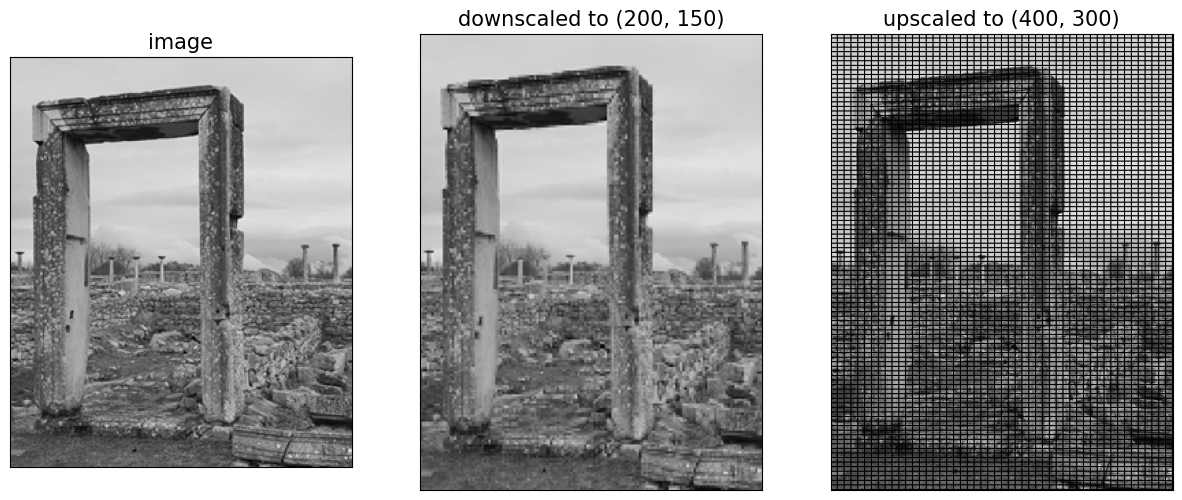

In [11]:
def scaling(img, size):
    dest_h, dest_w = size
    dest_img = np.zeros(size, dtype="uint8")

    src_h, src_w = img.shape[:2]
    for y in range(src_h):
        for x in range(src_w):
            new_y, new_x = int(y * (dest_h / src_h)), int(x * (dest_w / src_w))
            dest_img[new_y][new_x] = img[y][x]

    return dest_img

image = cv2.imread("./images/chap08/scaling.jpg", cv2.IMREAD_GRAYSCALE)
print("원본 이미지 크기: ", image.shape)

downscaled = scaling(image, (200, 150))
upscaled = scaling(image, (400, 300))
show_images({"image": image, "downscaled to (200, 150)": downscaled, "upscaled to (400, 300)": upscaled}, 15)

- ### 축소한 이미지에서 오버랩 발생
- ### 확대한 이미지에서 홀 발생

---

- ## 보간 (interpolation)
    - ### 역방향 사상
        - ### 목적 영상의 좌표를 중심으로 해당하는 원본 영상의 좌표를 찾아 화소값을 가져오는 방식
    - ### 확대 시 홀의 화소들을 입력 영상에서 찾아 목적 영상의 화소에 대입
    - ### 축소 시 오버랩 발생하지 않게 화소를 배치하여 목적 영상 만들기

<br>

- ## 1. 최근접 이웃 보간법
    - ### 홀에 가장 가깝게 이웃한 입력영상의 화소값을 가져오는 방법
    - ### cv2.resize(image, size, fx, fy, cv2.INTER_NEAREST)
 
        ![image](https://github.com/kks00/visual_info_processing/assets/68108664/5f9862e1-2f66-4422-aa24-06a4dc8b2878)

    - # $ y = \frac{y'}{\frac{destHeight}{srcHeight}} $
    - # $ x = \frac{x'}{\frac{destWidth}{srcWidth}} $

원본 이미지 크기:  (300, 250)


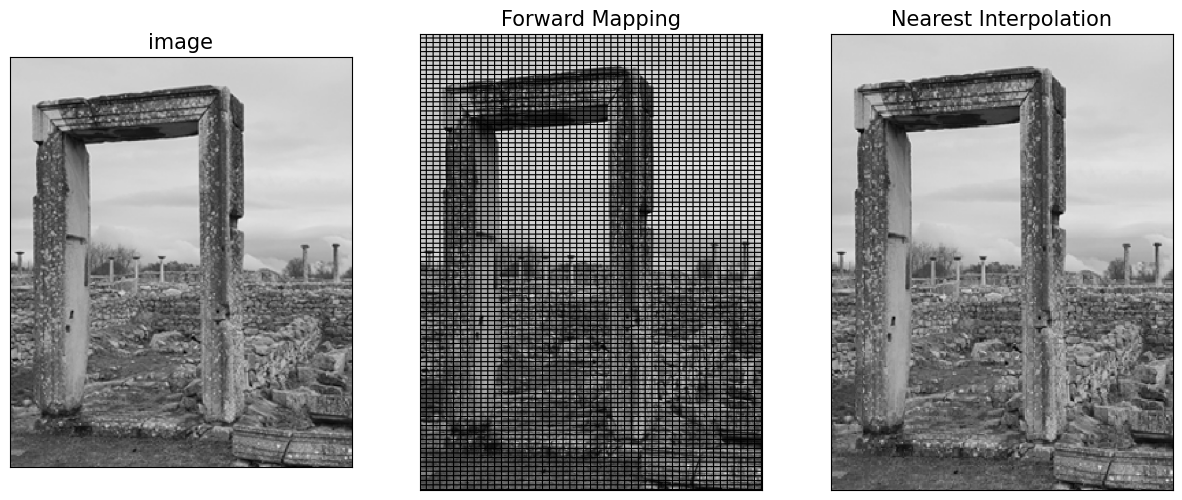

In [12]:
def scaling_nearest(img, size):
    src_h, src_w = img.shape[:2]

    dest_h, dest_w = size
    dest_img = np.zeros(size, dtype="uint8")
    for y in range(dest_h):
        for x in range(dest_w):
            src_y, src_x = int(y / (dest_h / src_h)), int(x / (dest_w / src_w))
            dest_img[y][x] = img[src_y][src_x]

    return dest_img

image = cv2.imread("./images/chap08/scaling.jpg", cv2.IMREAD_GRAYSCALE)
print("원본 이미지 크기: ", image.shape)

upscaled_forward_mapping = scaling(image, (400, 300))
upscaled_nearest_interpolation = scaling_nearest(image, (400, 300))
show_images({"image": image, "Forward Mapping": upscaled_forward_mapping, "Nearest Interpolation": upscaled_nearest_interpolation}, 15)

<br><br>

- ## 2. 양선형 보간법
    - ### 최근접 이웃 보간법에서 모자이크 현상을 보완하기 위한 방법
    - ### cv2.resize(image, size, fx, fy, cv2.INTER_LINEAR)

    <br>

    ![image](https://github.com/kks00/visual_info_processing/assets/68108664/ac568c89-7c26-4cba-9af7-fb4588745106)

    - #### $ P_1, P_2, P_3, P_4 $ = 최근접 보간법에 의한 원본 이미지에서의 가까운 위치의 4개 화소
    - #### $ \alpha $, $ \beta $ = 원본 이미지에서의 픽셀 x, y축 위치의 소수점 이하 값

    <br>

    - #### $ M_1 = \alpha * P_3 + (1 - \alpha) * P_1 $
    - #### $ M_2 = \alpha * P_4 + (1 - \alpha) * P_2 $

![image](https://github.com/kks00/visual_info_processing/assets/68108664/b36d9626-84d9-46b7-9eac-e73fbce7e0cf)

- #### 최종 화소값 $ P = M_2 * \beta + M_1 * (1 - \beta) $

<br>

원본 이미지 크기:  (150, 141)


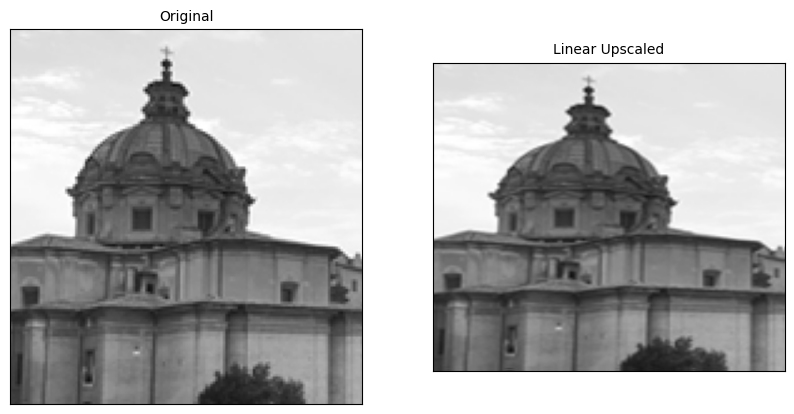

In [74]:
image = cv2.imread("./images/chap08/interpolation.jpg", cv2.IMREAD_GRAYSCALE)
print("원본 이미지 크기: ", image.shape[:2])

new_h, new_w = (350, 400) # 변경할 이미지 크기

def linear_interpolation(orig_img, new_size):
    orig_h, orig_w = orig_img.shape[:2]
    new_image = np.zeros(new_size, dtype="uint8")
    new_h, new_w = new_size
    ratio_y, ratio_x = (new_h / orig_h, new_w / orig_w)

    for y in range(new_h):
        for x in range(new_w):
            orig_y, orig_x = (y / ratio_y, x / ratio_x) # 최근접 보간법으로 원본 영상 좌표 구하기
            alpha, beta = (orig_y - int(orig_y), orig_x - int(orig_x))

            roi_y_start = min(orig_h - 2, int(orig_y)) # 영상 범위 벗어남 처리
            roi_x_start = min(orig_w - 2, int(orig_x))
            P1, P2, P3, P4 = orig_img[roi_y_start: roi_y_start + 2, roi_x_start: roi_x_start + 2].flatten() # 가까운 위치의 P1~P4 가져오기
            
            M1 = P3 * alpha + P1 * (1 - alpha)
            M2 = P4 * alpha + P2 * (1 - alpha)
            P = M2 * beta + M1 * (1 - beta)
            
            P = np.clip(P, 0, 255) # 화소 클램프 처리
            new_image.itemset((y, x), P)

    return new_image

linear_upscaled = linear_interpolation(image, (new_h, new_w))
#linear_upscaled = cv2.resize(image, (new_h, new_w), 0, 0, cv2.INTER_LINEAR)

show_images({"Original": image, "Linear Upscaled": linear_upscaled}, 10)

---